In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file


### parameters

In [37]:
# _fname = "../replays/local.log"
_fname = "../replays/log11.log"
# _fname = "../replays/selftrade-rev.log"
_time_step = 100
_max_time = 200000
_num_close_turns = 30
_symbols = ["BANANAS", "PEARLS"]
_products = ["BANANAS", "PEARLS"]


In [41]:
(df["turn"].max() - df["turn"]) >= _num_close_turns

turn
0        True
1        True
2        True
3        True
4        True
        ...  
1994    False
1995    False
1996    False
1997    False
1998    False
Name: turn, Length: 1999, dtype: bool

### pre processing

In [5]:
# load data from file

obj = process_file(_fname)
df = pd.DataFrame(obj)

listings = pd.DataFrame(df["listings"][0])
# products = set(listings.T["product"])
df = df.drop("listings", axis=1)
df = df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(df["time"])
print("num missing_times", len(missing_times))
print("missing_times", missing_times)


Reading from input file ../replays/log11.log
num missing_times 1
missing_times {182700}


In [6]:
# add turns (vs time)

all_times = df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
df["turn"] = df["time"].map(time2turn_map)

df.index = df["turn"]

In [7]:
book_data = []
book_cols = []
    

for sym in _symbols:
    ### buys
    col = df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x: sorted(list(x["buy_orders"].items()), reverse=True))
    col = col.apply(lambda x: max(x)[0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x: list(x["sell_orders"].items()))
    col = col.apply(lambda x: min(x)[0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].fillna(method="backfill")
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = df["time"]



In [8]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 1999
Remaining count: 1999
nan count: 0


In [9]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

In [10]:
def flatten_trades(df, col, is_me):
    # get market trades

    data = []
    for index, row  in df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

In [11]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")


# filter market trades (only keep those where order_time = fill_time)
market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]


trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
# trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]


In [12]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 192 	volume: 242
[MY]	 count: 335 	volume: 964
[MY]	 vol%: 79.93%
PEARLS
[THEM]	 count: 104 	volume: 194
[MY]	 count: 350 	volume: 548
[MY]	 vol%: 73.85%


In [13]:
# get my_positions
my_positions = pd.DataFrame(list(df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
pos_data = []
cur_positions = { prod: 0 for prod in _products }
cur_positions["cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

cur_time = turn2time_map[0]

def record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data):
    global my_positions
    
    # copy orig pos
    pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_turn = time2turn_map[cur_time]
        
    # init fixed_positions for this turn
    for prod in _products:
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        fixed_positions[prod] += diff
        fixed_positions["cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]
    
    
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
        cur_time = turn2time_map[len(pos_data)]
        
    prod = listings[row["symbol"]]["product"]
    # update cur
    cur_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed
    fixed_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
    cur_time = turn2time_map[len(pos_data)]

record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(pos_data).sort_index(axis=1)

# add to my_positions
my_positions["cash"] = pos_df["cash"]
my_positions = my_positions.sort_index(axis=1)


try:
    for prod in ["cash", *_products]:
        bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
        if len(bad_inds) > 0:
            print("true pos")
            display(my_positions.loc[bad_inds])
            print("calculated pos")
            display(pos_df.loc[bad_inds])
            assert False, f"Failed check for product: `{prod}`"
except AssertionError:
    traceback.print_exc()
    
    print("Using fixed_pos_df['cash']")
    fixed_pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)
    my_positions["cash"] = fixed_pos_df["cash"]

### Data analysis/vis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

### todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [14]:
# estimate fairs
mid_cols = [col for col in book_tops.columns if "_mid" in col]
fairs = book_tops[["time", *mid_cols]]
fairs.columns = fairs.columns.str.strip('_mid')
fairs

,time,BANANAS,PEARLS
turn,,,
0,0,4896.0,10001.5
1,100,4894.0,9999.0
2,200,4895.5,10000.0
3,300,4896.0,10000.0
4,400,4896.5,10001.0
...,...,...,...
1994,199500,4908.5,10000.0
1995,199600,4908.5,10000.0
1996,199700,4908.0,10000.0


In [15]:
# estimate pnl
pnls = my_positions["cash"]

for prod in _products:
    pnls = pnls + my_positions[prod] * fairs[prod]
    
my_positions["pnl"] = pnls

In [16]:
# plot trades
def plot_trades_and_book(sym, smooth_alpha=0.1):
    
    plt_df = trade_df[trade_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="gray", s=10)
    

    bids = book_tops[f"{sym}_best_buy"]
    asks = book_tops[f"{sym}_best_sell"]
    smooth_bids = bids.ewm(alpha=smooth_alpha).mean()
    smooth_asks = asks.ewm(alpha=smooth_alpha).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    
    # plot book
    ax = axes[0]
    ax.plot(df["time"], bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(df["time"], asks, c="red", alpha=0.5, linewidth=0.5)
    plot_trades(ax)
    ax.set_title(f"Trades and book: {sym}")
    
    ax = axes[1]
    ax.plot(df["time"], smooth_bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(df["time"], smooth_asks, c="red", alpha=0.75, linewidth=0.5)
    ax.set_title(f"(smooth) Trades and book: {sym}")
    plot_trades(ax)

    plt.show()
    

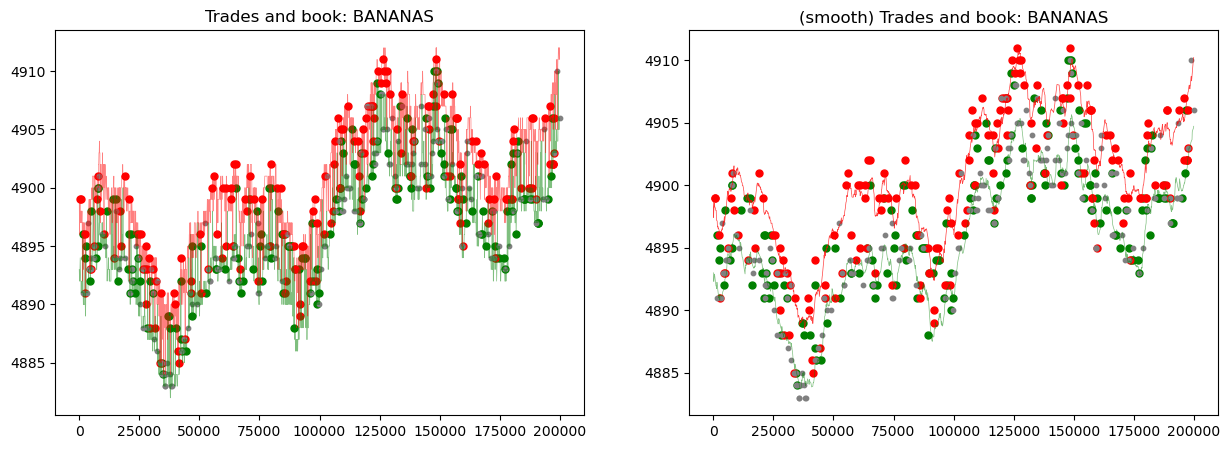

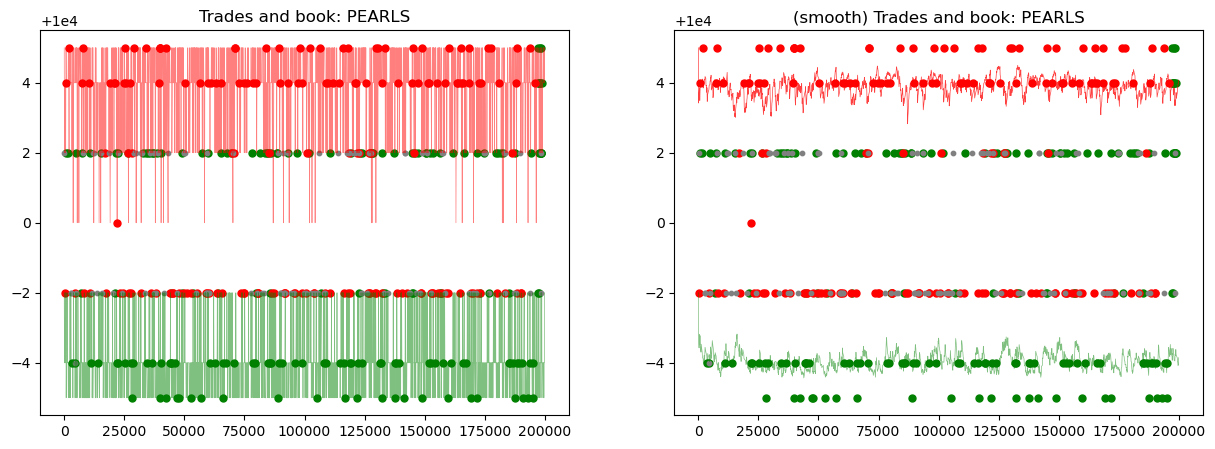

In [17]:
plot_trades_and_book(sym="BANANAS", smooth_alpha=0.1)
plot_trades_and_book(sym="PEARLS")

Text(0.5, 1.0, 'PNL')

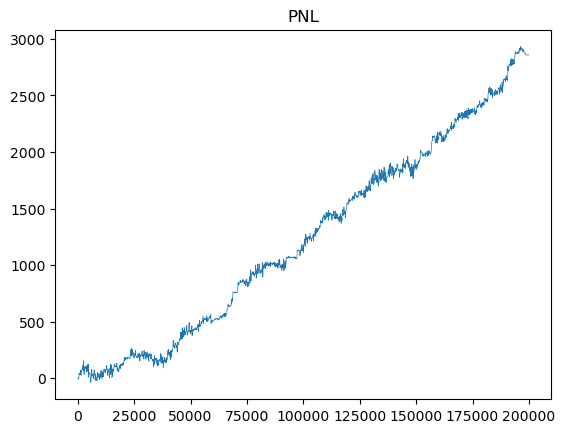

In [18]:
plt.plot(my_positions["time"], my_positions["pnl"], linewidth=0.5)
plt.title("PNL")

In [19]:
my_positions

,BANANAS,PEARLS,cash,time,turn,pnl
0,0.0,0.0,0.0,0,0,0.0
1,0.0,0.0,0.0,100,1,0.0
2,0.0,0.0,0.0,200,2,0.0
3,0.0,0.0,0.0,300,3,0.0
4,0.0,-3.0,29994.0,400,4,-9.0
...,...,...,...,...,...,...
1994,0.0,0.0,2858.0,199500,1994,2858.0
1995,0.0,0.0,2858.0,199600,1995,2858.0
1996,0.0,0.0,2858.0,199700,1996,2858.0
1997,0.0,0.0,2858.0,199800,1997,2858.0


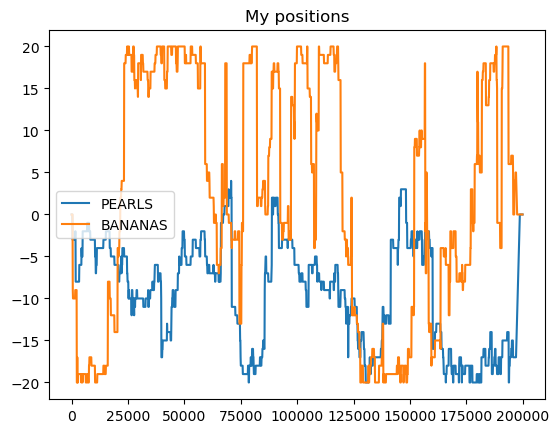

In [20]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

In [21]:
# distribution of price movements

col = book_tops[["BANANAS_mid", "PEARLS_mid"]]
diffs = (col.shift(-1) / col).dropna()
diffs.describe().T

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,1998.0,1.000001,0.000338,0.998777,0.999822,1.0,1.000204,1.001227
PEARLS_mid,1998.0,1.000000,0.000104,0.999600,0.999900,1.0,1.000100,1.000350


In [22]:
trades = my_trades[my_trades["symbol"] == "BANANAS"]


In [23]:
trades[["quantity"]].describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,335.0,2.877612,3.761602,0.0,1.0,1.0,2.0,20.0


In [24]:
df["book"][0]["BANANAS"]

{'buy_orders': {'4892': 30, '4893': 1}, 'sell_orders': {'4899': -30}}

In [25]:
df["book"][0]

{'BANANAS': {'buy_orders': {'4892': 30, '4893': 1},
  'sell_orders': {'4899': -30}},
 'PEARLS': {'buy_orders': {'9995': 30, '9998': 1},
  'sell_orders': {'10005': -30}}}

In [26]:
my_trades[my_trades["buyer"].apply(lambda x : x not in ["SUBMISSION", ""]) | my_trades["seller"].apply(lambda x : x not in ["SUBMISSION", ""])]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade


In [27]:
market_trades

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade
0,,10002.0,1,,PEARLS,100,100,1,False,False,False,0,False
6,,4891.0,1,,BANANAS,1400,1400,14,False,False,False,0,False
13,,9998.0,5,,PEARLS,2700,2700,27,False,False,False,0,False
14,,9998.0,1,,PEARLS,2900,2900,29,False,False,False,0,False
16,,4891.0,1,,BANANAS,3100,3100,31,False,False,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,,4903.0,1,,BANANAS,197700,197700,1976,False,False,False,0,False
974,,9998.0,1,,PEARLS,198400,198400,1983,False,False,False,0,False
975,,10002.0,3,,PEARLS,198500,198500,1984,False,False,False,0,False
979,,4910.0,1,,BANANAS,198900,198900,1988,False,False,False,0,False


In [31]:
market_trades

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade
0,,10002.0,1,,PEARLS,100,100,1,False,False,False,0,False
6,,4891.0,1,,BANANAS,1400,1400,14,False,False,False,0,False
13,,9998.0,5,,PEARLS,2700,2700,27,False,False,False,0,False
14,,9998.0,1,,PEARLS,2900,2900,29,False,False,False,0,False
16,,4891.0,1,,BANANAS,3100,3100,31,False,False,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,,4903.0,1,,BANANAS,197700,197700,1976,False,False,False,0,False
974,,9998.0,1,,PEARLS,198400,198400,1983,False,False,False,0,False
975,,10002.0,3,,PEARLS,198500,198500,1984,False,False,False,0,False
979,,4910.0,1,,BANANAS,198900,198900,1988,False,False,False,0,False


In [28]:
df["time"]

turn
0            0
1          100
2          200
3          300
4          400
         ...  
1994    199500
1995    199600
1996    199700
1997    199800
1998    199900
Name: time, Length: 1999, dtype: int64

In [29]:
df["market_trades"][1]

{'PEARLS': [{'buyer': '',
   'price': 10002.0,
   'quantity': 1,
   'seller': '',
   'symbol': 'PEARLS',
   'timestamp': 100,
   'time': 100,
   'turn': 1}]}

In [30]:
my_trades

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade
1,,9998.0,3,SUBMISSION,PEARLS,300,400,4,True,False,True,-3,False
2,,4899.0,9,SUBMISSION,BANANAS,400,500,5,True,False,True,-9,False
3,SUBMISSION,10002.0,1,,PEARLS,500,600,6,True,True,False,1,False
4,,4899.0,1,SUBMISSION,BANANAS,500,600,6,True,False,True,-1,False
5,,10004.0,1,SUBMISSION,PEARLS,500,600,6,True,False,True,-1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,SUBMISSION,10002.0,1,,PEARLS,198200,198300,1982,True,True,False,1,False
973,SUBMISSION,10002.0,1,,PEARLS,198300,198400,1983,True,True,False,1,False
976,SUBMISSION,10005.0,1,,PEARLS,198400,198500,1984,True,True,False,1,False
977,SUBMISSION,10002.0,1,,PEARLS,198500,198600,1985,True,True,False,1,False


In [36]:
pnls[-50:]

1949    2869.0
1950    2885.0
1951    2885.5
1952    2889.0
1953    2873.5
1954    2871.5
1955    2881.0
1956    2880.5
1957    2917.0
1958    2900.0
1959    2900.0
1960    2900.0
1961    2917.0
1962    2899.0
1963    2933.0
1964    2914.0
1965    2910.0
1966    2905.0
1967    2912.5
1968    2917.5
1969    2917.5
1970    2914.0
1971    2902.5
1972    2890.0
1973    2897.0
1974    2884.0
1975    2903.0
1976    2905.0
1977    2888.0
1978    2884.0
1979    2880.0
1980    2881.0
1981    2878.0
1982    2875.0
1983    2864.5
1984    2866.0
1985    2862.0
1986    2858.0
1987    2858.0
1988    2858.0
1989    2858.0
1990    2858.0
1991    2858.0
1992    2858.0
1993    2858.0
1994    2858.0
1995    2858.0
1996    2858.0
1997    2858.0
1998    2858.0
dtype: float64